In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import statcast_pitcher, playerid_lookup, statcast
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

In [3]:
### Select Pitcher first and last name
first_name = "Freddy"
last_name = "Peralta"

In [4]:
def get_pitcher_id(first_name, last_name):
    """Look up pitcher ID by name"""
    try:
        player_info = playerid_lookup(last_name, first_name)
        if len(player_info) > 0:
            return player_info.iloc[0]['key_mlbam']
        else:
            print(f"No player found for {first_name} {last_name}")
            return None
    except Exception as e:
        print(f"Error looking up player: {e}")
        return None

def get_pitcher_data(pitcher_id, start_date, end_date):
    """Get pitcher's Statcast data for a date range"""
    try:
        data = statcast_pitcher(start_date, end_date, pitcher_id)
        return data
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None
    
# Get pitcher ID
pitcher_id = get_pitcher_id(first_name, last_name)
if pitcher_id:
    print(f"Found pitcher ID: {pitcher_id} for {first_name} {last_name}")
else:
    print("Please check the pitcher name and try again")


Gathering player lookup table. This may take a moment.
Found pitcher ID: 642547 for Freddy Peralta


In [5]:
# Get current year data
current_year = datetime.now().year
season_start = f"{current_year}-03-01"
season_end = datetime.now().strftime("%Y-%m-%d")

print(f"Fetching {current_year} season data...")
season_data = get_pitcher_data(pitcher_id, season_start, season_end)

if season_data is not None and len(season_data) > 0:
    # Get last start data (most recent game date)
    season_data['game_date'] = pd.to_datetime(season_data['game_date'])
    last_game_date = season_data['game_date'].max()
    last_start_data = season_data[season_data['game_date'] == last_game_date].copy()
    
    print(f"Season data: {len(season_data)} pitches")
    print(f"Last start ({last_game_date.strftime('%Y-%m-%d')}): {len(last_start_data)} pitches")
    
    # Clean data - remove nulls in key columns
    season_data = season_data.dropna(subset=['pfx_x', 'pfx_z', 'pitch_type'])
    last_start_data = last_start_data.dropna(subset=['pfx_x', 'pfx_z', 'pitch_type'])
else:
    print("No data found. Please check pitcher name and dates.")

def create_movement_plot(data, title, ax=None):
    """Create a pitch movement plot"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # Define colors for different pitch types
    pitch_colors = {
        'FF': '#FF6B6B',    # 4-seam fastball - red
        'SI': '#4ECDC4',    # sinker - teal  
        'FC': '#45B7D1',    # cutter - blue
        'SL': '#96CEB4',    # slider - green
        'CU': '#FFEAA7',    # curveball - yellow
        'CH': '#DDA0DD',    # changeup - purple
        'FS': '#FFB347',    # splitter - orange
        'KC': '#98D8C8',    # knuckle curve - mint
        'KN': '#F7DC6F',    # knuckleball - light yellow
        'EP': '#BB8FCE'     # eephus - light purple
    }
    
    # Plot each pitch type
    for pitch_type in data['pitch_type'].unique():
        if pd.notna(pitch_type):
            pitch_data = data[data['pitch_type'] == pitch_type]
            color = pitch_colors.get(pitch_type, '#95A5A6')  # Default gray
            
            ax.scatter(pitch_data['pfx_x'] * -12,  # Convert to inches
                      pitch_data['pfx_z'] * 12,  # Convert to inches  
                      c=color, 
                      s=60, 
                      alpha=0.7,
                      label=f"{pitch_type} ({len(pitch_data)})",
                      edgecolors='black',
                      linewidth=0.5)
    
    # Formatting
    ax.set_xlabel('Horizontal Movement (inches)', fontsize=12)
    ax.set_ylabel('Vertical Movement (inches)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add reference lines
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Set axis limits to center the plot nicely
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    
    return ax

Fetching 2025 season data...
Gathering Player Data
Season data: 2110 pitches
Last start (2025-07-13): 103 pitches


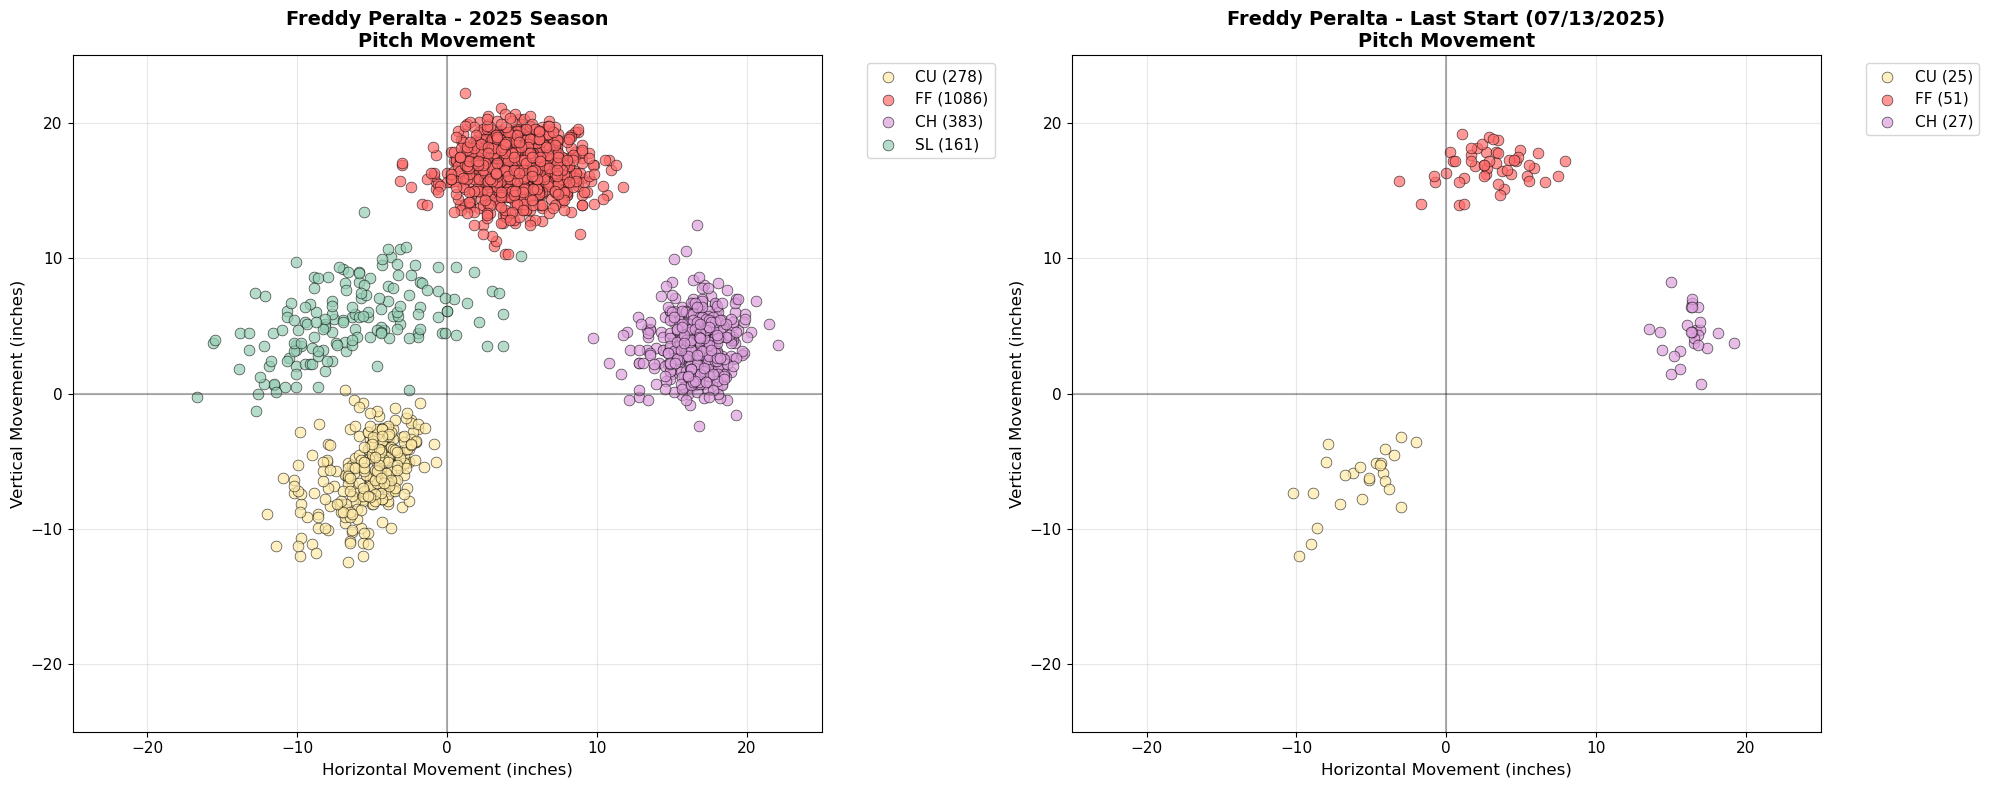

In [6]:
if 'season_data' in locals() and len(season_data) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Season movement plot
    create_movement_plot(season_data, 
                        f"{first_name} {last_name} - {current_year} Season\nPitch Movement", 
                        ax1)
    
    # Last start movement plot
    create_movement_plot(last_start_data, 
                        f"{first_name} {last_name} - Last Start ({last_game_date.strftime('%m/%d/%Y')})\nPitch Movement", 
                        ax2)
    
    plt.tight_layout()
    plt.show()

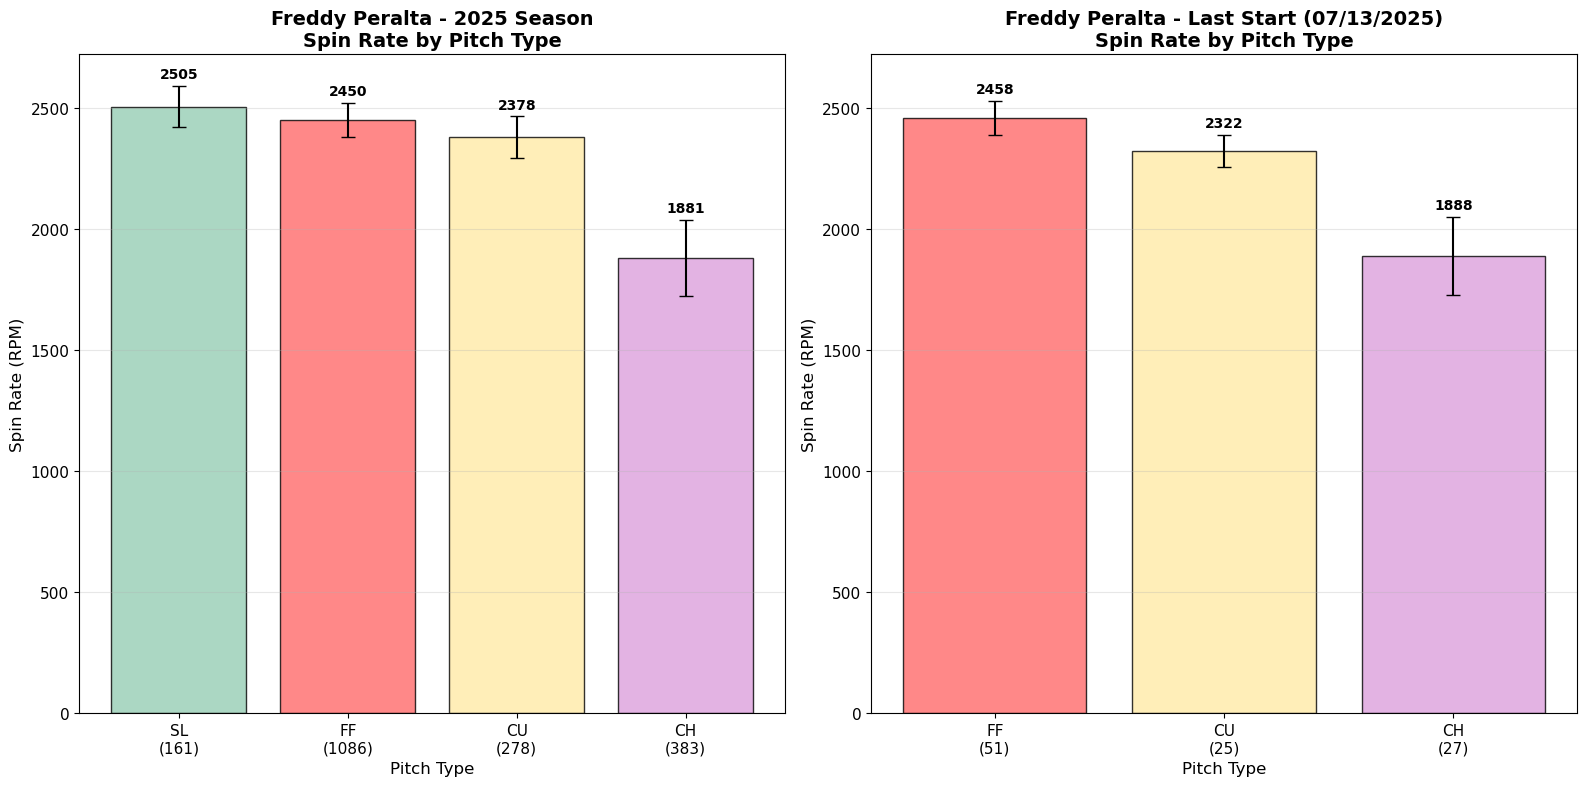

In [7]:
def plot_spin_rate_comparison():
    """Compare spin rates between season and last start"""
    # Check which spin rate column is available
    spin_col = None
    if 'release_spin_rate' in season_data.columns:
        spin_col = 'release_spin_rate'
    elif 'spin_rate' in season_data.columns:
        spin_col = 'spin_rate'
    
    if spin_col is None:
        print("No spin rate data available in this dataset")
        return
    
    # Clean data - remove null spin rates
    season_clean = season_data.dropna(subset=[spin_col, 'pitch_type'])
    last_clean = last_start_data.dropna(subset=[spin_col, 'pitch_type'])
    
    if len(season_clean) == 0 or len(last_clean) == 0:
        print("Insufficient spin rate data for comparison")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Define colors for pitch types (same as movement plots)
    pitch_colors = {
        'FF': '#FF6B6B', 'SI': '#4ECDC4', 'FC': '#45B7D1', 'SL': '#96CEB4',
        'CU': '#FFEAA7', 'CH': '#DDA0DD', 'FS': '#FFB347', 'KC': '#98D8C8',
        'KN': '#F7DC6F', 'EP': '#BB8FCE'
    }
    
    # Season spin rate plot
    season_spin_stats = season_clean.groupby('pitch_type')[spin_col].agg(['mean', 'std', 'count']).reset_index()
    season_spin_stats = season_spin_stats.sort_values('mean', ascending=False)
    
    colors_season = [pitch_colors.get(pitch, '#95A5A6') for pitch in season_spin_stats['pitch_type']]
    
    bars1 = ax1.bar(range(len(season_spin_stats)), 
                    season_spin_stats['mean'],
                    yerr=season_spin_stats['std'],
                    color=colors_season,
                    alpha=0.8,
                    capsize=5,
                    edgecolor='black',
                    linewidth=1)
    
    ax1.set_xlabel('Pitch Type', fontsize=12)
    ax1.set_ylabel('Spin Rate (RPM)', fontsize=12)
    ax1.set_title(f'{first_name} {last_name} - {current_year} Season\nSpin Rate by Pitch Type', 
                  fontsize=14, fontweight='bold')
    ax1.set_xticks(range(len(season_spin_stats)))
    ax1.set_xticklabels([f"{pitch}\n({count})" for pitch, count in 
                        zip(season_spin_stats['pitch_type'], season_spin_stats['count'])])
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (bar, mean_val, std_val) in enumerate(zip(bars1, season_spin_stats['mean'], season_spin_stats['std'])):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + std_val + 20,
                f'{mean_val:.0f}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Last start spin rate plot
    last_spin_stats = last_clean.groupby('pitch_type')[spin_col].agg(['mean', 'std', 'count']).reset_index()
    last_spin_stats = last_spin_stats.sort_values('mean', ascending=False)
    
    colors_last = [pitch_colors.get(pitch, '#95A5A6') for pitch in last_spin_stats['pitch_type']]
    
    bars2 = ax2.bar(range(len(last_spin_stats)), 
                    last_spin_stats['mean'],
                    yerr=last_spin_stats['std'],
                    color=colors_last,
                    alpha=0.8,
                    capsize=5,
                    edgecolor='black',
                    linewidth=1)
    
    ax2.set_xlabel('Pitch Type', fontsize=12)
    ax2.set_ylabel('Spin Rate (RPM)', fontsize=12)
    ax2.set_title(f'{first_name} {last_name} - Last Start ({last_game_date.strftime("%m/%d/%Y")})\nSpin Rate by Pitch Type', 
                  fontsize=14, fontweight='bold')
    ax2.set_xticks(range(len(last_spin_stats)))
    ax2.set_xticklabels([f"{pitch}\n({count})" for pitch, count in 
                        zip(last_spin_stats['pitch_type'], last_spin_stats['count'])])
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (bar, mean_val, std_val) in enumerate(zip(bars2, last_spin_stats['mean'], last_spin_stats['std'])):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + std_val + 20,
                f'{mean_val:.0f}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Make y-axis scales consistent for better comparison
    y_min = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
    y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
    ax1.set_ylim(y_min, y_max)
    ax2.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    plt.show()
    
if 'season_data' in locals() and len(season_data) > 0:
    plot_spin_rate_comparison()

In [8]:
def create_summary_stats():
    """Create summary statistics comparison"""
    print("="*80)
    print(f"{first_name} {last_name} - PERFORMANCE SUMMARY")
    print("="*80)
    
    available_cols = season_data.columns.tolist()
    
    # Build aggregation dictionary based on available columns
    agg_dict = {}
    if 'release_speed' in available_cols:
        agg_dict['release_speed'] = ['mean', 'std']
    if 'pfx_x' in available_cols:
        agg_dict['pfx_x'] = 'mean'
    if 'pfx_z' in available_cols:
        agg_dict['pfx_z'] = 'mean'
    if 'release_spin_rate' in available_cols:
        agg_dict['release_spin_rate'] = 'mean'
    elif 'spin_rate' in available_cols:
        agg_dict['spin_rate'] = 'mean'
    
    # Season summary
    print(f"\n{current_year} SEASON SUMMARY:")
    print("-" * 50)
    
    if agg_dict:
        season_summary = season_data.groupby('pitch_type').agg(agg_dict).round(2)
    
    pitch_counts = season_data['pitch_type'].value_counts()
    pitch_pcts = (season_data['pitch_type'].value_counts() / len(season_data) * 100).round(1)
    
    for pitch in pitch_counts.index:
        print(f"{pitch}: {pitch_counts[pitch]} pitches ({pitch_pcts[pitch]}%)")
        if agg_dict and pitch in season_summary.index:
            # Velocity stats
            if 'release_speed' in agg_dict:
                speed_mean = season_summary.loc[pitch, ('release_speed', 'mean')]
                speed_std = season_summary.loc[pitch, ('release_speed', 'std')]
                print(f"  Avg Velocity: {speed_mean:.1f} ± {speed_std:.1f} mph")
            
            # Movement stats
            if 'pfx_x' in agg_dict and 'pfx_z' in agg_dict:
                h_mov = season_summary.loc[pitch, ('pfx_x', 'mean')] * 12
                v_mov = season_summary.loc[pitch, ('pfx_z', 'mean')] * 12
                print(f"  Movement: {h_mov:+.1f}″ H, {v_mov:+.1f}″ V")
            
            # Spin rate stats
            spin_col = None
            if 'release_spin_rate' in agg_dict:
                spin_col = 'release_spin_rate'
            elif 'spin_rate' in agg_dict:
                spin_col = 'spin_rate'
            
            if spin_col:
                spin = season_summary.loc[pitch, (spin_col, 'mean')]
                if not pd.isna(spin):
                    print(f"  Avg Spin Rate: {spin:.0f} rpm")
        print()
    
    # Last start summary
    print(f"\nLAST START SUMMARY ({last_game_date.strftime('%Y-%m-%d')}):")
    print("-" * 50)
    
    if agg_dict:
        last_summary = last_start_data.groupby('pitch_type').agg(agg_dict).round(2)
    
    last_counts = last_start_data['pitch_type'].value_counts()
    last_pcts = (last_start_data['pitch_type'].value_counts() / len(last_start_data) * 100).round(1)
    
    for pitch in last_counts.index:
        print(f"{pitch}: {last_counts[pitch]} pitches ({last_pcts[pitch]}%)")
        if agg_dict and pitch in last_summary.index:
            # Velocity stats
            if 'release_speed' in agg_dict:
                speed_mean = last_summary.loc[pitch, ('release_speed', 'mean')]
                speed_std = last_summary.loc[pitch, ('release_speed', 'std')]
                print(f"  Avg Velocity: {speed_mean:.1f} ± {speed_std:.1f} mph")
            
            # Movement stats  
            if 'pfx_x' in agg_dict and 'pfx_z' in agg_dict:
                h_mov = last_summary.loc[pitch, ('pfx_x', 'mean')] * 12
                v_mov = last_summary.loc[pitch, ('pfx_z', 'mean')] * 12
                print(f"  Movement: {h_mov:+.1f}″ H, {v_mov:+.1f}″ V")
            
            # Spin rate stats
            if spin_col:
                spin = last_summary.loc[pitch, (spin_col, 'mean')]
                if not pd.isna(spin):
                    print(f"  Avg Spin Rate: {spin:.0f} rpm")
        print()

if 'season_data' in locals() and len(season_data) > 0:
    create_summary_stats()

Freddy Peralta - PERFORMANCE SUMMARY

2025 SEASON SUMMARY:
--------------------------------------------------
FF: 1086 pitches (56.9%)
  Avg Velocity: 94.9 ± 1.4 mph
  Movement: -4.7″ H, +16.8″ V
  Avg Spin Rate: 2450 rpm

CH: 383 pitches (20.1%)
  Avg Velocity: 89.2 ± 1.1 mph
  Movement: -16.7″ H, +3.6″ V
  Avg Spin Rate: 1881 rpm

CU: 278 pitches (14.6%)
  Avg Velocity: 79.9 ± 1.5 mph
  Movement: +5.3″ H, -5.8″ V
  Avg Spin Rate: 2378 rpm

SL: 161 pitches (8.4%)
  Avg Velocity: 84.1 ± 1.2 mph
  Movement: +6.4″ H, +5.4″ V
  Avg Spin Rate: 2505 rpm


LAST START SUMMARY (2025-07-13):
--------------------------------------------------
FF: 51 pitches (49.5%)
  Avg Velocity: 95.0 ± 1.2 mph
  Movement: -2.9″ H, +16.8″ V
  Avg Spin Rate: 2458 rpm

CH: 27 pitches (26.2%)
  Avg Velocity: 89.0 ± 1.0 mph
  Movement: -16.2″ H, +4.4″ V
  Avg Spin Rate: 1888 rpm

CU: 25 pitches (24.3%)
  Avg Velocity: 78.2 ± 2.1 mph
  Movement: +5.8″ H, -6.5″ V
  Avg Spin Rate: 2322 rpm

